In [6]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from trajectory import Trajectory
from robot_state import RobotState
from motion_profiles import JointMotionProfile, RobotMotionProfile
from kinematic_utils import (
    calculate_positions,
    get_robot_states_from_cartesian_waypoints,
    generate_cartesian_waypoints_on_line,
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_motion_profiles(trajectory: Trajectory):
    profiles = trajectory.get_motion_profiles()
    joints_count = len(profiles[0].joint_mps)
    fig, (ax_pos, ax_vel, ax_acc) = plt.subplots(3, joints_count, figsize=(7 * joints_count, 12))
    for _, robot_mp in profiles.items():
        times = np.linspace(robot_mp.initial_time, robot_mp.total_time(), 100)
        positions = [robot_mp.position_at(t) for t in times]
        velocities = [robot_mp.velocity_at(t) for t in times]
        accelerations = [robot_mp.acceleration_at(t) for t in times]
        for j in range(len(robot_mp.joint_mps)):
            ax_pos[j].plot(times, [p[j] for p in positions], c="b")
            ax_vel[j].plot(times, [v[j] for v in velocities], c="r")
            ax_acc[j].plot(times, [a[j] for a in accelerations], c="g")

            ax_pos[j].axvline(x=times[-1], color="k", linestyle="--")
            ax_vel[j].axvline(x=times[-1], color="k", linestyle="--")
            ax_acc[j].axvline(x=times[-1], color="k", linestyle="--")

            ax_pos[j].set_title(f"Joint {j}")
            ax_pos[j].set_xlabel("Time (s)")
            ax_pos[j].set_ylabel("Position (m)")
            ax_vel[j].set_xlabel("Time (s)")
            ax_vel[j].set_ylabel("Velocity (m/s)")
            ax_acc[j].set_xlabel("Time (s)")
            ax_acc[j].set_ylabel("Acceleration (m/s²)")

    fig.suptitle("Joint Motion Profiles on Steroids", y=0.93)
    plt.show()

In [8]:
def plot_trajectory_in_joint_space(
    trajectory: Trajectory, way_points: list[RobotState], j0_index: int = 0, j1_index: int = 1
):
    timed_robot_states = trajectory.trace(time_step=0.01)

    joints0 = [state.values()[j0_index] for _, state in timed_robot_states]
    joints1 = [state.values()[j1_index] for _, state in timed_robot_states]

    plt.scatter(joints0, joints1, s=1, color="blue")  # Set the size of dots to 10
    plt.xlabel(f"Joint {j0_index}")
    plt.ylabel(f"Joint {j1_index}")

    plt.title("Trajectory in Joint Space")
    way_points_j0 = [state.values()[j0_index] for state in way_points]
    way_points_j1 = [state.values()[j1_index] for state in way_points]
    plt.scatter(way_points_j0, way_points_j1, color="red", s=20)

    way_points_indices: list[int] = []
    for waypoint_j0, waypoint_j1 in zip(way_points_j0, way_points_j1):
        distances = [(j0 - waypoint_j0) ** 2 + (j1 - waypoint_j1) ** 2 for j0, j1 in zip(joints0, joints1)]
        index = distances.index(min(distances))
        way_points_indices.append(index)

    # Add time value to each base point
    for i, (x, y) in enumerate(zip(way_points_j0, way_points_j1)):
        idx = way_points_indices[i]
        time_val = f"{timed_robot_states[idx][0]:.2f}"
        plt.text(x + 0.05, y, f"time={time_val} s", fontsize=14, ha="left")  # Add time value to each base point

    plt.show()

### Manual Waypoints List

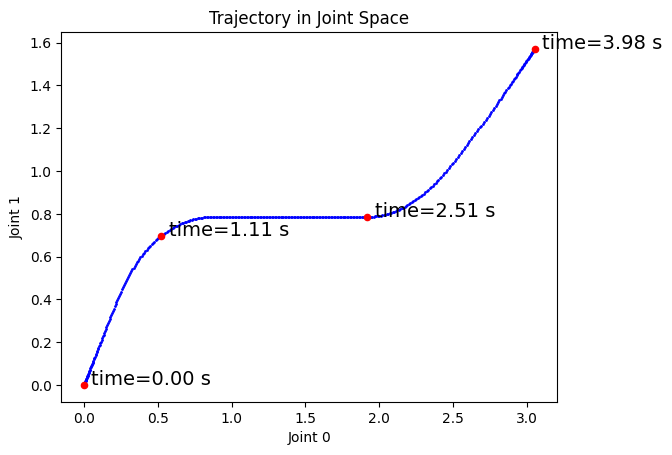

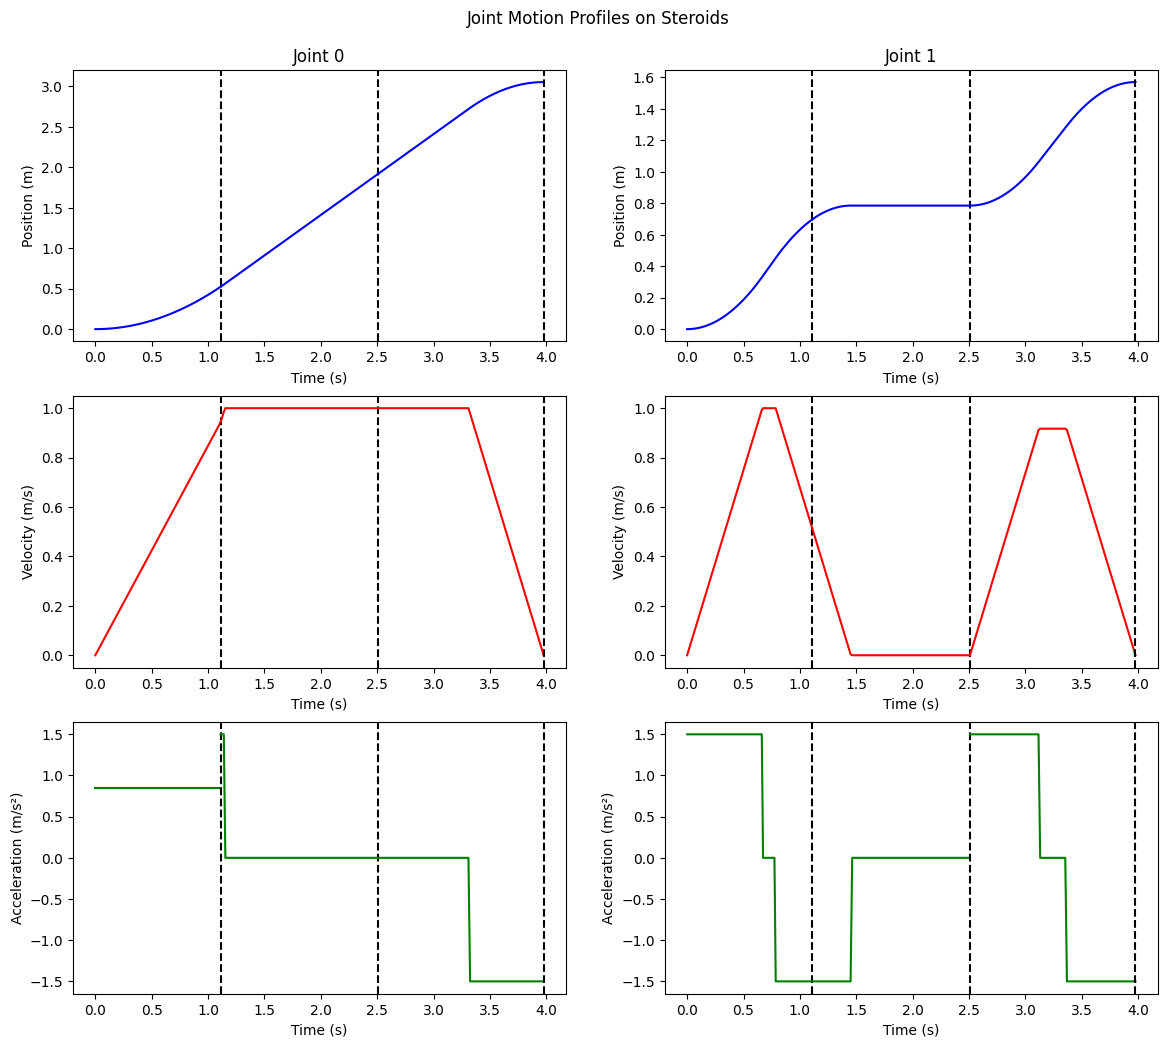

In [9]:
max_velocity = 1  # radians per second
max_acceleration = 1.5  # radians per second squared

waypoints = [
    RobotState([np.deg2rad(0), np.deg2rad(0)]),
    RobotState([np.deg2rad(30), np.deg2rad(40)]),
    RobotState([np.deg2rad(110), np.deg2rad(45)]),
    RobotState([np.deg2rad(175), np.deg2rad(90)]),
]
trajectory = Trajectory(waypoints, max_velocity, max_acceleration)
plot_trajectory_in_joint_space(trajectory, waypoints)
plot_motion_profiles(trajectory)

### Cartesian Line Waypoints

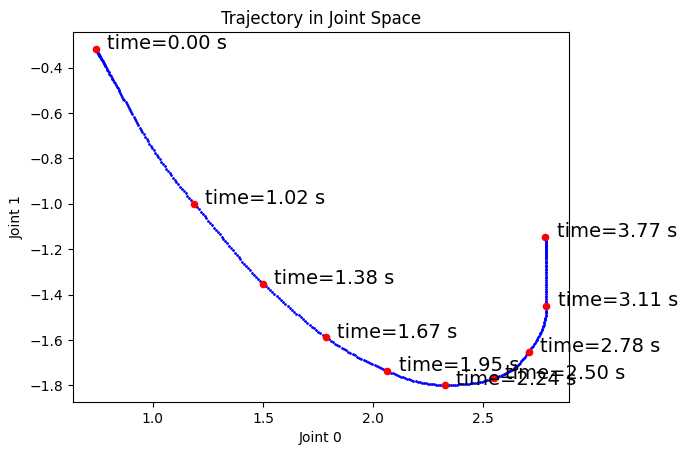

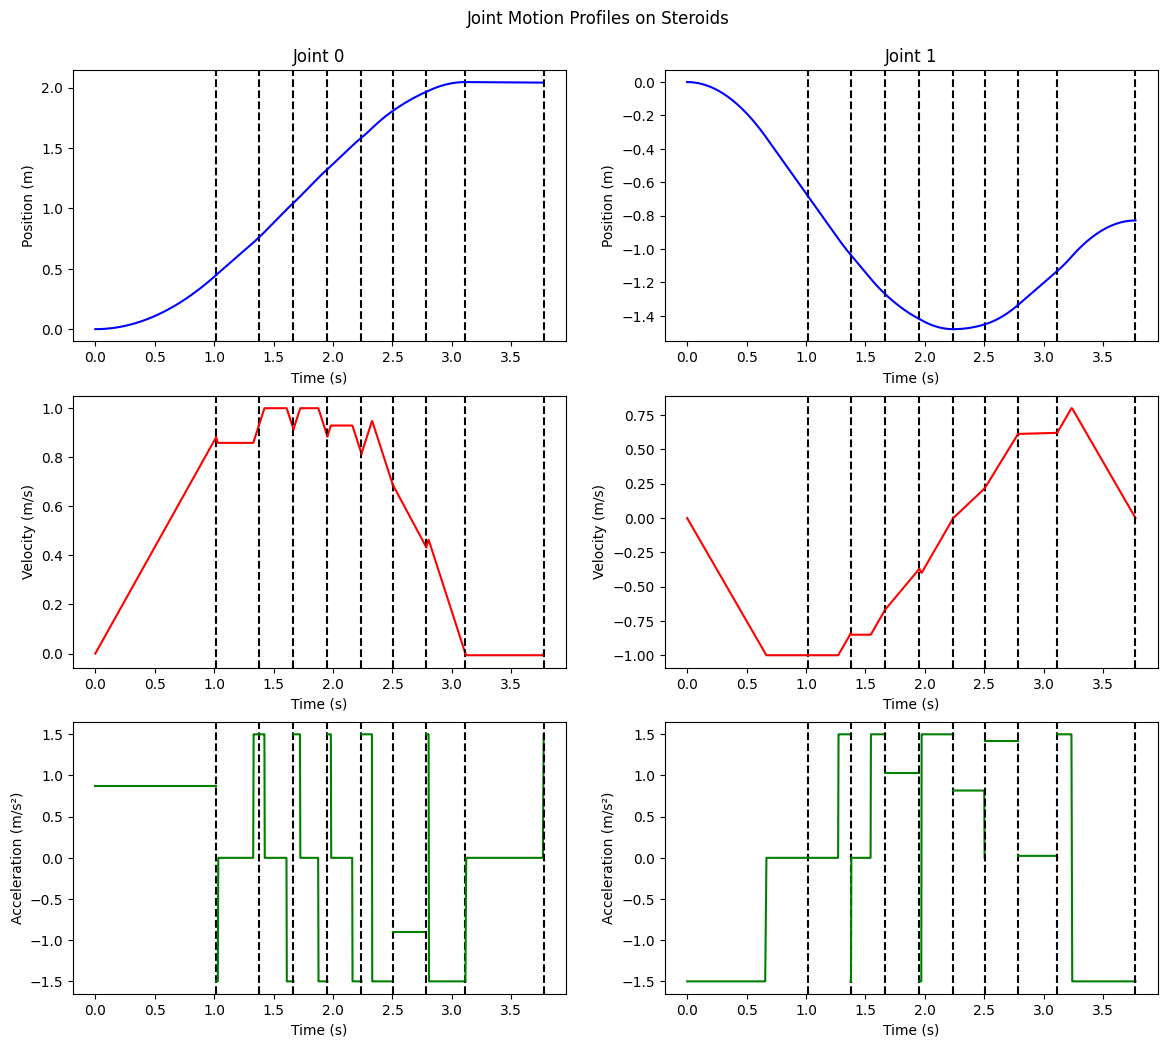

In [10]:
cartesian_waypoints = generate_cartesian_waypoints_on_line(
    line_slope=-0.1, line_intercept=2.5, x_start=3.3, x_end=-2, points_count=10
)

link1_length = 2.0
link2_length = 2.0
waypoints = get_robot_states_from_cartesian_waypoints(cartesian_waypoints, link1_length, link2_length, elbow_up=True)

trajectory = Trajectory(waypoints, max_velocity, max_acceleration)
plot_trajectory_in_joint_space(trajectory, waypoints)
plot_motion_profiles(trajectory)